# ASSIGNMENT 4

In [13]:
import itertools
import time
from functools import lru_cache
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from memory_profiler import memory_usage
import pandas as pd

def print_assignment(mapping: Dict[str, List[str]]) -> None:
    for crew, flights in mapping.items():
        print(f"{crew}: {flights}")


## Data model and sample input

In [3]:
# flights: list of tuples (flight_id, start_time, end_time)

sample_flights = [
    ('F1', 9, 11),
    ('F2', 10, 12),
    ('F3', 13, 15),
    ('F4', 11.5, 13),
    ('F5', 16, 18),
]

sample_crew = ['C1', 'C2', 'C3']

sample_costs = {
    ('C1', 'F1'): 10, ('C1', 'F2'): 8, ('C1', 'F3'): 7, ('C1', 'F4'): 5, ('C1', 'F5'): 6,
    ('C2', 'F1'): 9,  ('C2', 'F2'): 6, ('C2', 'F3'): 8, ('C2', 'F4'): 7, ('C2', 'F5'): 5,
    ('C3', 'F1'): 11, ('C3', 'F2'): 7, ('C3', 'F3'): 6, ('C3', 'F4'): 9, ('C3', 'F5'): 4,
}

## Constraint checker utilities

In [4]:
def flights_overlap(f1: Tuple[str, float, float], f2: Tuple[str, float, float], min_rest: float = 1.0) -> bool:
    _, s1, e1 = f1
    _, s2, e2 = f2
    if e1 <= s2:
        return (s2 - e1) < min_rest
    elif e2 <= s1:
        return (s1 - e2) < min_rest
    else:
        return True

def is_valid_assignment_for_crew(assigned_flights: List[Tuple[str, float, float]],
                                 candidate: Tuple[str, float, float],
                                 min_rest: float = 1.0) -> bool:
    for af in assigned_flights:
        if flights_overlap(af, candidate, min_rest=min_rest):
            return False
    return True

## Generate possible assignments per crew

In [5]:
def generate_nonoverlapping_combinations(flights: List[Tuple[str, float, float]],
                                         min_rest: float = 1.0) -> List[List[Tuple[str, float, float]]]:
    valid = []
    n = len(flights)
    for r in range(1 << n):
        subset = [flights[i] for i in range(n) if (r >> i) & 1]
        ok = True
        for a, b in itertools.combinations(subset, 2):
            if flights_overlap(a, b, min_rest=min_rest):
                ok = False
                break
        if ok:
            subset_sorted = sorted(subset, key=lambda x: x[1])
            valid.append(subset_sorted)
    return valid

## Backtracking assignment function

In [6]:
def assign_flights_backtracking(flights: List[Tuple[str, float, float]],
                                crew_members: List[str],
                                min_rest: float = 1.0,
                                costs: Optional[Dict[Tuple[str, str], float]] = None,
                                minimize_cost: bool = False,
                                find_all: bool = False,
                                time_limit_seconds: Optional[float] = None):
    start_time = time.time()
    n = len(flights)
    flight_by_id = {f[0]: f for f in flights}
    flight_ids = [f[0] for f in flights]
    best_solution = None
    best_cost = float('inf') if minimize_cost else None
    solutions = []

    # Keep track of assigned flights
    assigned = {c: [] for c in crew_members}
    used = set()

    # Order flights for assignment: heuristic -> sort by earlier start or longest duration
    flights_sorted = sorted(flights, key=lambda x: (x[1], -(x[2] - x[1])))

    # Helper to compute cost of current partial assignment
    def current_total_cost():
        if not costs:
            return 0
        s = 0
        for c, flist in assigned.items():
            for fid, _, _ in flist:
                s += costs.get((c, fid), 0)
        return s

    # backtracking recursive function: assign flights index by index
    call_count = 0
    def backtrack(idx=0):
        nonlocal best_solution, best_cost, call_count
        # time limit check
        if time_limit_seconds and (time.time() - start_time) > time_limit_seconds:
            return
        call_count += 1
        if idx >= len(flights_sorted):
            # all flights considered, return solution
            # check if any flights left unassigned -> this design tries every flight to be assigned
            if len(used) == len(flights):
                sol = {c: [f[0] for f in assigned[c]] for c in crew_members}
                cost_here = current_total_cost()
                if find_all:
                    solutions.append((sol, cost_here))
                else:
                    if minimize_cost:
                        if cost_here < best_cost:
                            best_cost = cost_here
                            best_solution = sol.copy()
                    else:
                        # first feasible solution found
                        if best_solution is None:
                            best_solution = sol.copy()
                            best_cost = cost_here
            return

        flight = flights_sorted[idx]
        fid = flight[0]

        # If already assigned indirectly (this happens if flight list contains duplicates), skip
        if fid in used:
            backtrack(idx + 1)
            return

        # Try to assign this flight to each crew member if valid
        assigned_flag = False
        for crew in crew_members:
            if is_valid_assignment_for_crew(assigned[crew], flight, min_rest=min_rest):
                # place
                assigned[crew].append(flight)
                used.add(fid)
                # pruning: if minimizing cost and partial cost already >= best_cost, prune
                if minimize_cost and best_cost is not None:
                    partial = current_total_cost()
                    if partial < best_cost:
                        backtrack(idx + 1)
                    # else prune
                else:
                    backtrack(idx + 1)
                # undo
                assigned[crew].pop()
                used.remove(fid)
                assigned_flag = True

        # Also consider leaving flight unassigned (if allowed). Many assignment setups require all flights assigned
        # If you require all flights to be assigned, remove this branch.
        # Here we'll NOT allow leaving flights unassigned by default. If you want to allow unassigned flights, uncomment:
        # backtrack(idx + 1)

    backtrack(0)
    if find_all:
        return solutions, call_count
    return (best_solution, best_cost, call_count, time.time() - start_time)

## Example run

In [7]:
result = assign_flights_backtracking(sample_flights, sample_crew, min_rest=1.0, costs=sample_costs, minimize_cost=False, find_all=False)
best_solution, best_cost, calls, elapsed = result
print("Calls:", calls, "Elapsed (s):", elapsed)
print("Solution (crew->flights):")
print_assignment(best_solution)
print("Cost (if any):", best_cost)

Calls: 64 Elapsed (s): 0.0010437965393066406
Solution (crew->flights):
C1: ['F1', 'F3', 'F5']
C2: ['F2']
C3: ['F4']
Cost (if any): 38


## Visualization - simple Gantt chart

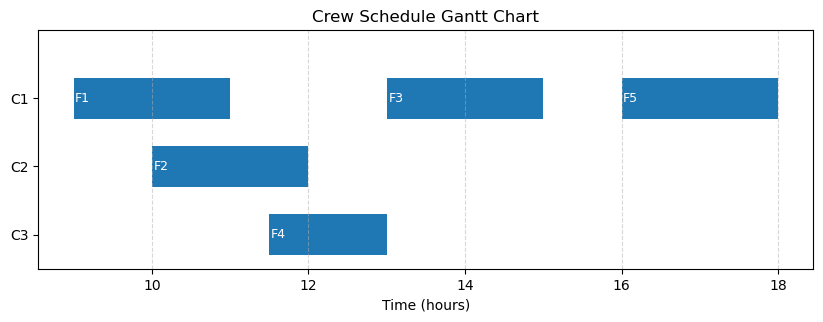

In [8]:
def plot_gantt(assignment: Dict[str, List[str]], flights: List[Tuple[str,float,float]]):
    fid_to_interval = {fid: (s, e) for fid, s, e in flights}
    crews = list(assignment.keys())
    fig, ax = plt.subplots(figsize=(10, 1 + 0.7 * len(crews)))
    yticks = []
    ylabels = []
    for i, crew in enumerate(crews):
        y = len(crews) - i
        yticks.append(y)
        ylabels.append(crew)
        for fid in assignment[crew]:
            s, e = fid_to_interval[fid]
            ax.broken_barh([(s, e - s)], (y - 0.3, 0.6))
            ax.text(s + 0.02, y, fid, va='center', ha='left', fontsize=9, color='white')
    ax.set_ylim(0.5, len(crews) + 1)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_xlabel("Time (hours)")
    ax.set_title("Crew Schedule Gantt Chart")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

# Example plotting the earlier solution:
if best_solution:
    plot_gantt(best_solution, sample_flights)


## Profiling - Time and Memory 

In [14]:
def profile_scaling(n_values=[4,5,6,7], trials=2, crew_count=3, min_rest=1.0):
    timings = []
    mems = []

    for n in n_values:
        t_total = 0
        m_total = 0
        for _ in range(trials):
            # generate random flights
            import random
            flights = []
            for i in range(n):
                s = round(random.uniform(6, 18), 2)
                dur = round(random.uniform(1, 3), 2)
                flights.append((f"F{i+1}", s, s + dur))
            
            crew = [f"C{i+1}" for i in range(crew_count)]

            # ---- Time measurement ----
            import time
            t0 = time.time()

            if memory_usage:
                mem_before = memory_usage()[0]
            else:
                mem_before = None

            result = assign_flights_backtracking(
                flights, crew, min_rest=min_rest,
                find_all=False, minimize_cost=False,
                time_limit_seconds=10
            )

            t1 = time.time()
            t_total += (t1 - t0)

            # ---- Memory measurement ----
            if memory_usage:
                mem_after = memory_usage()[0]
                m_total += max(0, mem_after - mem_before)
            else:
                m_total += None

        timings.append(round(t_total / trials, 4))
        mems.append(round(m_total / trials, 4) if m_total else None)

    # ---- Build DataFrame ----
    df = pd.DataFrame({
        "Flights (n)": n_values,
        "Avg Time (sec)": timings,
        "Avg Memory Used (MiB)": mems
    })
    return df


# Run the profiling
df_results = profile_scaling([4,5,6], trials=2)

# Display neatly
df_results.style.set_caption("Execution Time & Memory Usage for Backtracking")

,Flights (n),Avg Time (sec),Avg Memory Used (MiB)
0,4,0.101100,None
1,5,0.100600,None
2,6,0.100300,None


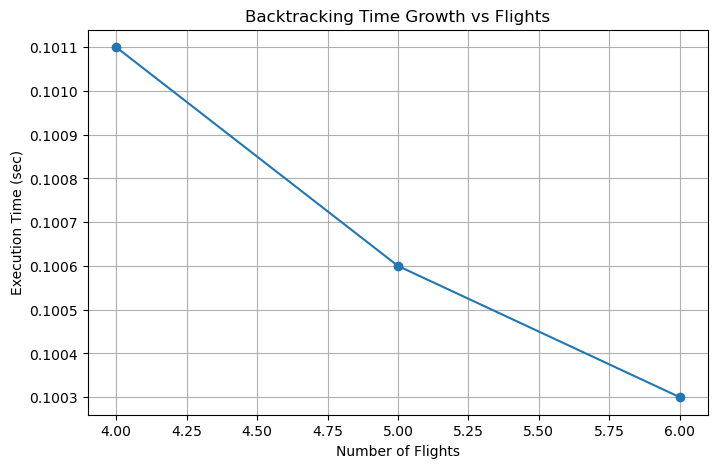

In [16]:
plt.figure(figsize=(8,5))

plt.plot(df_results["Flights (n)"], df_results["Avg Time (sec)"], marker='o')
plt.xlabel("Number of Flights")
plt.ylabel("Execution Time (sec)")
plt.title("Backtracking Time Growth vs Flights")
plt.grid(True)
plt.show()

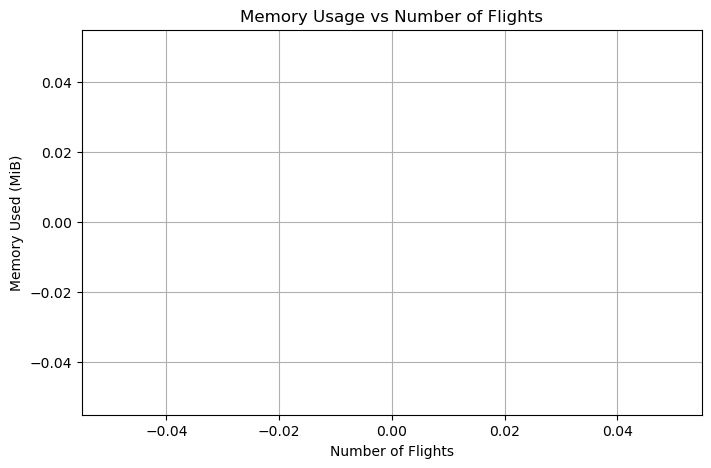

In [18]:
plt.figure(figsize=(8,5))
plt.plot(df_results["Flights (n)"], df_results["Avg Memory Used (MiB)"], marker='o')
plt.xlabel("Number of Flights")
plt.ylabel("Memory Used (MiB)")
plt.title("Memory Usage vs Number of Flights")
plt.grid(True)
plt.show()